# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'
    
models_path = utils.get_m5_root_dir() + '/models/'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4912.94 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(53662400, 34)
(44307636, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [45]:
params_cat_id_0 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
    'num_leaves': 2^8,
}

params_cat_id_1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
    'num_leaves': 2^8,
}

params_cat_id_2 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.25,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
    'num_leaves': 2^9,
}

In [46]:


  # to record eval results for plotting


for cat in df_merged.cat_id.drop_duplicates():
    
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    evals_result = {}
    start = time.time()
    
    if cat == 0:
        params = params_cat_id_0
    elif cat == 1:
        params = params_cat_id_1
    elif cat == 2:
        params = params_cat_id_2
    else:
        raise ValueError(f'Cat_id not in [0,1,2].')
    
    print('log: create data sets')
    x_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    x_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    print('log: create LightGBM data sets')
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )

    print('log: model training')
    gbm= lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                    fobj=custom_mse_asymmetric_loss,
                    feval=custom_rmse_asymmetric_valid
                   )
    
    
    print('log: save model and evals result')
    gbm.save_model(f'{models_path}gbm_cat_id_{cat}_{prefix}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    print('\n Training for cat_id %s took %0.2f minutes.' %(cat, (time.time()-start)/60))




 ***** Computation for cat_id  1 *****
log: create data sets
log: create LightGBM data sets
log: model training


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.87791	valid_1's custom_mse_asymmetric_eval: 1.73294
[50]	training's custom_mse_asymmetric_eval: 1.85992	valid_1's custom_mse_asymmetric_eval: 1.72279
[75]	training's custom_mse_asymmetric_eval: 1.85296	valid_1's custom_mse_asymmetric_eval: 1.72076
[100]	training's custom_mse_asymmetric_eval: 1.84837	valid_1's custom_mse_asymmetric_eval: 1.72117
Early stopping, best iteration is:
[82]	training's custom_mse_asymmetric_eval: 1.85165	valid_1's custom_mse_asymmetric_eval: 1.72053
log: save model and evals result

 Training for cat_id 1 took -4.21 minutes.

 ***** Computation for cat_id  2 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.63858	valid_1's custom_mse_asymmetric_eval: 1.53228
[50]	training's custom_mse_asymmetric_eval: 1.61879	valid_1's cu

In [47]:
# 12min 51s

In [48]:


# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]
x_pred['y_pred'] = np.nan


for cat in x_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    x_pred.loc[x_pred.cat_id == cat,'y_pred'] = mod.predict(x_pred.loc[x_pred.cat_id == cat][features])

    

# Training Analysis


 ***** Computation for cat_id  1 *****


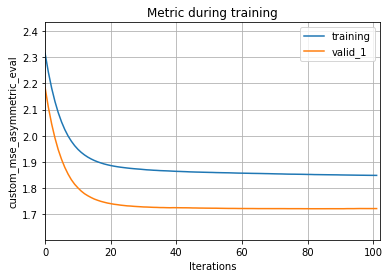

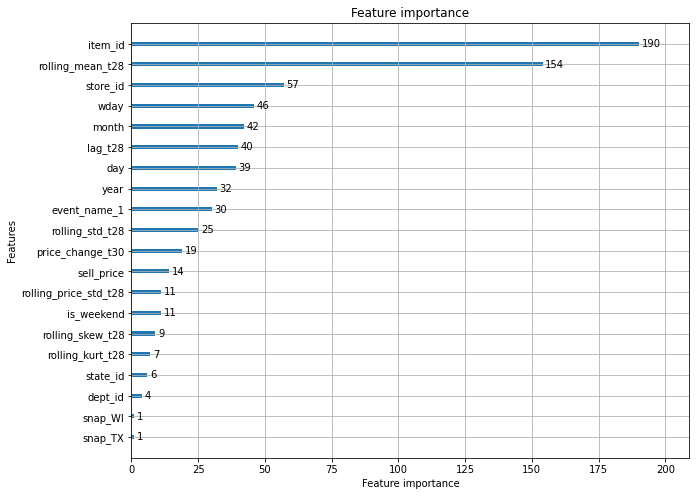


 ***** Computation for cat_id  2 *****


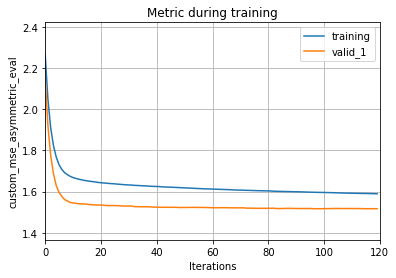

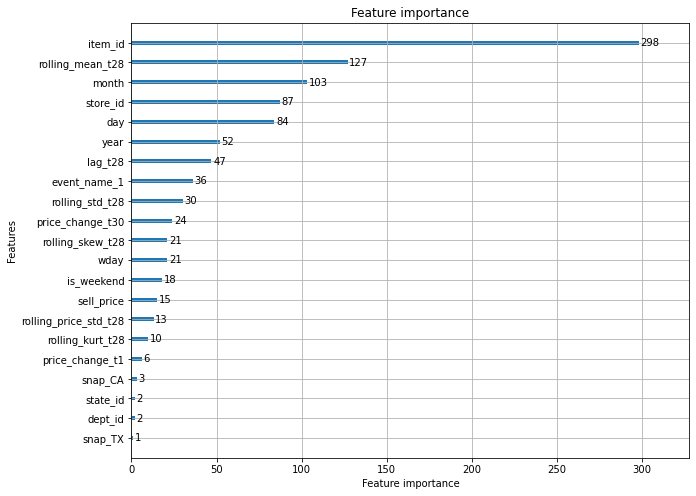


 ***** Computation for cat_id  0 *****


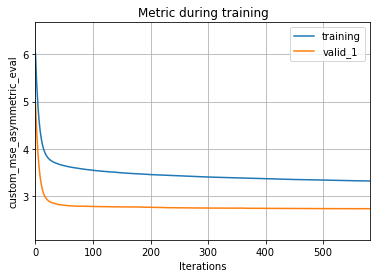

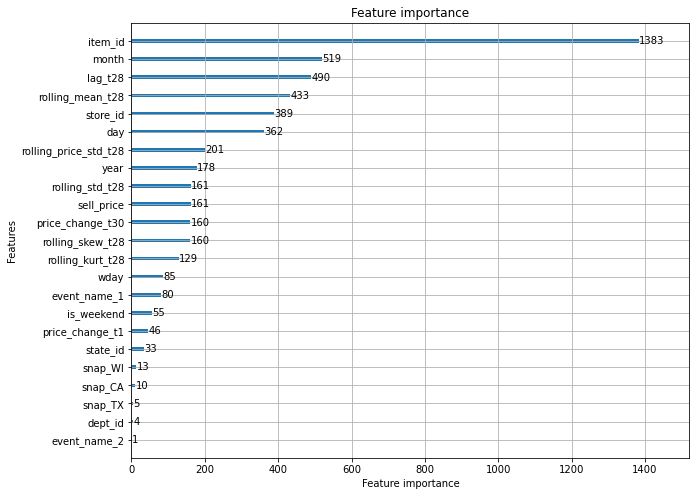

In [49]:
for cat in x_pred.cat_id.drop_duplicates():
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    evals = pickle.load(open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.show()
    


# Compute RMSSE and WRMSSE on Validation Data

In [50]:
# compute forecasts, error and map it to df_merged to get ids

# create validation set containing all categories
df_tmp = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
df_tmp['y_true'] = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27']['sale'].copy()

for cat in df_tmp.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    df_tmp.loc[df_tmp.cat_id == cat,'y_pred'] = mod.predict(df_tmp.loc[df_tmp.cat_id == cat][features])
    
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp.head(10)

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_true,y_pred,error,id
0,1437,3,1,0,0,2016,3,28,0,3,...,1.423363,1.000000,1.231763,0.0,0.0,8.622286e-08,1.0,0.858149,0.141851,HOBBIES_1_001_CA_1_validation
1,1437,3,1,0,0,2016,3,29,0,4,...,1.310783,1.033333,1.245221,0.0,0.0,8.622286e-08,0.0,0.920787,-0.920787,HOBBIES_1_001_CA_1_validation
2,1437,3,1,0,0,2016,3,30,0,5,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.853313,-0.853313,HOBBIES_1_001_CA_1_validation
3,1437,3,1,0,0,2016,3,31,0,6,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.871897,-0.871897,HOBBIES_1_001_CA_1_validation
4,1437,3,1,0,0,2016,4,1,0,7,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.971561,-0.971561,HOBBIES_1_001_CA_1_validation
5,1437,3,1,0,0,2016,4,2,1,1,...,1.356940,0.966667,1.272612,0.0,0.0,8.622286e-08,0.0,1.051509,-1.051509,HOBBIES_1_001_CA_1_validation
6,1437,3,1,0,0,2016,4,3,1,2,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,1.0,1.068444,-0.068444,HOBBIES_1_001_CA_1_validation
7,1437,3,1,0,0,2016,4,4,0,3,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.858149,-0.858149,HOBBIES_1_001_CA_1_validation
8,1437,3,1,0,0,2016,4,5,0,4,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,4.0,0.853313,3.146687,HOBBIES_1_001_CA_1_validation
9,1437,3,1,0,0,2016,4,6,0,5,...,1.444642,0.966667,1.245221,0.0,0.0,8.622286e-08,2.0,0.862730,1.137270,HOBBIES_1_001_CA_1_validation


In [51]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_tmp.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [52]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [53]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01167

WRMSSE = 0.88675


In [54]:
# show RMSSE and corresponding weights
rmsse_df.sort_values(by='weights', ascending=False).head(20)

,RMSSE,id,weights,w_times_RMSSE
15906,0.877025,HOBBIES_1_158_TX_3_validation,0.003642,0.003194
17826,0.748498,HOBBIES_1_354_TX_3_validation,0.003544,0.002652
948,1.336886,FOODS_1_096_WI_2_validation,0.002928,0.003915
7322,1.080559,FOODS_3_120_CA_3_validation,0.002494,0.002695
17825,0.786773,HOBBIES_1_354_TX_2_validation,0.001698,0.001336
7320,1.096781,FOODS_3_120_CA_1_validation,0.001423,0.001561
17820,0.903697,HOBBIES_1_354_CA_1_validation,0.001416,0.001280
7468,1.144103,FOODS_3_134_WI_2_validation,0.001402,0.001604
7022,0.377299,FOODS_3_090_CA_3_validation,0.001319,0.000498
946,1.028998,FOODS_1_096_TX_3_validation,0.001309,0.001347


In [55]:
# analyse time series (manually)
rel_id = 'FOODS_1_096_WI_2_validation'
df_tmp.loc[df_tmp.id == rel_id][[
    'id',
    'month',
    'day',
    'up_for_sale',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'is_weekend',
    'wday',
    'sell_price',
    'y_pred',
    'y_true',
    'error',
]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
730744,FOODS_1_096_WI_2_validation,3,28,1,13,1,3,1,0,3,7.23,45.527399,43.0,-2.527399
730745,FOODS_1_096_WI_2_validation,3,29,1,13,1,3,1,0,4,7.23,47.773929,50.0,2.226071
730746,FOODS_1_096_WI_2_validation,3,30,1,13,1,3,1,0,5,7.23,44.881432,50.0,5.118568
730747,FOODS_1_096_WI_2_validation,3,31,1,13,1,3,1,0,6,7.23,45.331007,48.0,2.668993
730748,FOODS_1_096_WI_2_validation,4,1,1,13,1,3,1,0,7,7.23,61.115061,82.0,20.884939
730749,FOODS_1_096_WI_2_validation,4,2,1,13,1,3,1,1,1,7.23,49.184690,52.0,2.815310
730750,FOODS_1_096_WI_2_validation,4,3,1,13,1,3,1,1,2,7.23,52.214473,44.0,-8.214473
730751,FOODS_1_096_WI_2_validation,4,4,1,13,1,3,1,0,3,7.23,51.022025,61.0,9.977975
730752,FOODS_1_096_WI_2_validation,4,5,1,13,1,3,1,0,4,7.23,44.900683,54.0,9.099317
730753,FOODS_1_096_WI_2_validation,4,6,1,13,1,3,1,0,5,7.23,54.219892,37.0,-17.219892


# Printout Forecasts

In [56]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
52808680,1437,3,1,0,0,2016,4,25,0,3,...,8.38,1.0,0.246603,0.763245,1.033333,0.927858,0.0,0.0,5.968164e-02,0.871722
52808681,1438,3,1,0,0,2016,4,25,0,3,...,3.97,1.0,-1.731692,0.744880,0.333333,0.479463,0.0,0.0,0.000000e+00,0.327434
52808682,1439,3,1,0,0,2016,4,25,0,3,...,2.97,0.0,16.585960,3.904594,0.500000,1.167077,0.0,0.0,0.000000e+00,0.460814
52808683,1440,3,1,0,0,2016,4,25,0,3,...,4.64,0.0,-0.529831,0.790924,1.966667,2.075860,0.0,0.0,0.000000e+00,1.833383
52808684,1441,3,1,0,0,2016,4,25,0,3,...,2.88,1.0,-0.717982,0.542001,1.100000,0.959526,0.0,0.0,4.434852e-08,0.988636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53662395,1432,2,0,9,2,2016,5,22,1,2,...,2.98,1.0,6.029183,2.758372,0.200000,0.550861,0.0,0.0,7.810822e-08,0.479998
53662396,1433,2,0,9,2,2016,5,22,1,2,...,2.48,0.0,1.580669,1.621490,0.300000,0.534983,0.0,0.0,4.964984e-08,0.362858
53662397,1434,2,0,9,2,2016,5,22,1,2,...,3.98,0.0,1.720479,1.485839,0.866667,1.136642,0.0,0.0,0.000000e+00,0.918199
53662398,1435,2,0,9,2,2016,5,22,1,2,...,1.28,3.0,-0.140881,0.963120,1.066667,1.172481,0.0,0.0,0.000000e+00,1.460714


In [57]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [58]:
id_mapping_table

,id,item_id,year,month,day,store_id
1,HOBBIES_1_002_CA_1_validation,1438,2011,7,29,0
3,HOBBIES_1_004_CA_1_validation,1440,2011,7,29,0
4,HOBBIES_1_005_CA_1_validation,1441,2011,7,29,0
7,HOBBIES_1_008_CA_1_validation,1444,2011,7,29,0
8,HOBBIES_1_009_CA_1_validation,1445,2011,7,29,0
...,...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,1432,2016,5,22,9
53662396,FOODS_3_824_WI_3_validation,1433,2016,5,22,9
53662397,FOODS_3_825_WI_3_validation,1434,2016,5,22,9
53662398,FOODS_3_826_WI_3_validation,1435,2016,5,22,9


In [59]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [60]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.828738,0.708397,0.701391,0.657837,1.010709,0.930572,1.049874,1.370445,1.118002,...,1.168287,1.469195,1.402543,1.410835,1.060756,1.052225,0.970613,1.014006,1.291266,1.137559
1,FOODS_1_001_CA_2_validation,0.730932,0.660691,0.653685,0.653685,0.693681,0.854394,0.973696,0.727690,0.680371,...,0.582346,0.629162,2.635551,1.063389,0.951908,0.943377,1.125354,0.930469,1.112487,1.544228
2,FOODS_1_001_CA_3_validation,1.170331,1.068000,1.104547,0.970876,1.049546,1.365388,1.369572,1.295150,1.247832,...,1.340735,1.543802,3.232287,1.634427,1.375120,1.298660,1.275512,1.344216,1.537619,1.479154
3,FOODS_1_001_CA_4_validation,0.500578,0.336683,0.329677,0.329677,0.408347,0.514922,0.611439,0.684387,0.588978,...,0.361154,0.460217,0.502700,0.465836,0.269962,0.252625,0.252262,0.373685,0.480108,0.486326
4,FOODS_1_001_TX_1_validation,0.385887,0.315646,0.308640,0.308640,0.387310,0.493886,0.610500,0.558861,0.529081,...,0.367403,0.463878,0.516167,0.348465,0.232225,0.223695,0.223332,0.277483,0.383906,0.383906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.273656,0.255536,0.262051,0.262051,0.293526,0.399281,0.413832,0.301297,0.292702,...,0.296536,0.493399,0.404069,0.285019,0.255536,0.265061,0.252526,0.296536,0.331453,0.318362
30486,HOUSEHOLD_2_516_TX_3_validation,0.177482,0.168887,0.165877,0.156351,0.197352,0.255588,0.284758,0.174701,0.178124,...,0.295220,0.230539,0.290500,0.228495,0.199012,0.199012,0.196002,0.240012,0.295238,0.282147
30487,HOUSEHOLD_2_516_WI_1_validation,0.098806,0.101816,0.098806,0.098806,0.127788,0.157046,0.186216,0.141066,0.144076,...,0.140323,0.154036,0.152308,0.110169,0.101816,0.101816,0.098806,0.130798,0.157046,0.143956
30488,HOUSEHOLD_2_516_WI_2_validation,0.104002,0.107012,0.104002,0.104002,0.132984,0.153915,0.183085,0.146262,0.149272,...,0.125829,0.140739,0.139012,0.105200,0.096847,0.096847,0.113527,0.135994,0.153915,0.140825


# Increase Predictions for Food Items as they are underestimated

In [61]:

food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)



In [62]:


submission_df.loc[submission_df.id.isin(food_list),
                  f_list] = submission_df.loc[submission_df.id.isin(food_list),
                                            f_list] * 1.4

submission_df



,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.828738,0.708397,0.701391,0.657837,1.010709,0.930572,1.049874,1.370445,1.118002,...,1.168287,1.469195,1.402543,1.410835,1.060756,1.052225,0.970613,1.014006,1.291266,1.137559
1,FOODS_1_001_CA_2_validation,0.730932,0.660691,0.653685,0.653685,0.693681,0.854394,0.973696,0.727690,0.680371,...,0.582346,0.629162,2.635551,1.063389,0.951908,0.943377,1.125354,0.930469,1.112487,1.544228
2,FOODS_1_001_CA_3_validation,1.170331,1.068000,1.104547,0.970876,1.049546,1.365388,1.369572,1.295150,1.247832,...,1.340735,1.543802,3.232287,1.634427,1.375120,1.298660,1.275512,1.344216,1.537619,1.479154
3,FOODS_1_001_CA_4_validation,0.500578,0.336683,0.329677,0.329677,0.408347,0.514922,0.611439,0.684387,0.588978,...,0.361154,0.460217,0.502700,0.465836,0.269962,0.252625,0.252262,0.373685,0.480108,0.486326
4,FOODS_1_001_TX_1_validation,0.385887,0.315646,0.308640,0.308640,0.387310,0.493886,0.610500,0.558861,0.529081,...,0.367403,0.463878,0.516167,0.348465,0.232225,0.223695,0.223332,0.277483,0.383906,0.383906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.273656,0.255536,0.262051,0.262051,0.293526,0.399281,0.413832,0.301297,0.292702,...,0.296536,0.493399,0.404069,0.285019,0.255536,0.265061,0.252526,0.296536,0.331453,0.318362
30486,HOUSEHOLD_2_516_TX_3_validation,0.177482,0.168887,0.165877,0.156351,0.197352,0.255588,0.284758,0.174701,0.178124,...,0.295220,0.230539,0.290500,0.228495,0.199012,0.199012,0.196002,0.240012,0.295238,0.282147
30487,HOUSEHOLD_2_516_WI_1_validation,0.098806,0.101816,0.098806,0.098806,0.127788,0.157046,0.186216,0.141066,0.144076,...,0.140323,0.154036,0.152308,0.110169,0.101816,0.101816,0.098806,0.130798,0.157046,0.143956
30488,HOUSEHOLD_2_516_WI_2_validation,0.104002,0.107012,0.104002,0.104002,0.132984,0.153915,0.183085,0.146262,0.149272,...,0.125829,0.140739,0.139012,0.105200,0.096847,0.096847,0.113527,0.135994,0.153915,0.140825


# Submit to Kaggle 

In [63]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation',
                          value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)